In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import ConcreteModel, Set, Param, Var, Objective, Constraint, SolverFactory, NonNegativeReals, minimize, Reals, Binary, value



In [29]:
#get fixed data
def get_fixed_data():
    """
    Returns the fixed data for the energy hub simulation.
    """
    num_timeslots = 24
    return {
        # Conversion efficiencies
        'conversion_p2h': 0.9,
        'conversion_h2p': 0.8,

        # Hydrogen storage capacity
        'hydrogen_capacity': 15,
        
        'p2h_max_rate': 5,
        'h2p_max_rate': 5,

        # Electrolyzer cost
        'electrolyzer_cost': 1, 

        # Wind model parameters
        'target_mean_wind': 4.5,
        'wind_reversion_strength': 0.15,
        'extreme_event_prob_wind': 0.03,

        # Price model parameters
        'mean_price': 35,
        'price_reversion_strength': 0.12,
        'wind_influence_on_price': -0.6,
        'price_cap': 90,  
        'price_floor': 0,
        
        
        'num_timeslots': num_timeslots,
        'demand_schedule': [5 + 2 * np.sin(2 * np.pi * t / 24) for t in range(num_timeslots)]

        
    }

data = get_fixed_data()

def price_model(current_price, previous_price, projected_wind, data):
    """
    Price process with dependence on previous prices and projected wind generation.

    Args:
        current_price (float): Current electricity price.
        previous_price (float): Electricity price at the previous time step.
        projected_wind (float): Projected wind generation for the next time step.
        data (dict): Fixed data containing model parameters.

    Returns:
        float: Next price.
    """
    mean_price = data['mean_price']
    reversion_strength = data['price_reversion_strength']
    wind_influence = data['wind_influence_on_price']
    price_cap = data['price_cap']
    price_floor = data['price_floor']

    mean_reversion = reversion_strength * (mean_price - current_price)
    wind_effect = wind_influence * projected_wind
    noise = np.random.normal(0, 1)

    next_price = current_price + 0.6 * (current_price - previous_price) + mean_reversion + wind_effect + noise

    if next_price < 0:
        if np.random.rand() > 0.2:
            next_price = np.random.uniform(0, mean_price * 0.3)

    return max(min(next_price, price_cap), price_floor)

def wind_model(current_wind, data):
    """
    Wind generation process with mean reversion and extreme events.

    Args:
        current_wind (float): Current wind generation.
        data (dict): Fixed data containing model parameters.

    Returns:
        float: Next wind generation.
    """
    target_mean = data['target_mean_wind']
    reversion_strength = data['wind_reversion_strength']
    extreme_event_prob = data['extreme_event_prob_wind']

    mean_reversion = reversion_strength * (target_mean - current_wind)
    noise = np.random.normal(0, 1)

    next_wind = current_wind + mean_reversion + noise

    if np.random.rand() < extreme_event_prob:
        next_wind += np.random.uniform(10, 20)

    return max(next_wind, 0)

def simulate_energy_hub(data, num_steps=100):
    """
    Simulates the energy hub over a specified number of time steps.

    Args:
        data (dict): Fixed data containing model parameters.
        num_steps (int): Number of time steps to simulate.

    Returns:
        pd.DataFrame: DataFrame containing the simulation results.
    """
    results = {
        'time': [],
        'price': [],
        'wind_generation': [],
        'demand': []
    }

    current_price = data['mean_price']
    previous_price = current_price
    current_wind = data['target_mean_wind']

    for t in range(num_steps):
        projected_wind = wind_model(current_wind, data)
        next_price = price_model(current_price, previous_price, projected_wind, data)

        results['time'].append(t)
        results['price'].append(next_price)
        results['wind_generation'].append(projected_wind)
        results['demand'].append(data['demand_schedule'][t % data['num_timeslots']])

        previous_price = current_price
        current_price = next_price
        current_wind = projected_wind

    return pd.DataFrame(results)

# Run the simulation
#simulation_results = simulate_energy_hub(data, num_steps=100)
#print(simulation_results.head())


In [30]:
# Extract trajectories from simulation results
wind_trajectory = simulation_results['wind_generation'].values[:data['num_timeslots']]
price_trajectory = simulation_results['price'].values[:data['num_timeslots']]

In [31]:

# Create Pyomo model
model = ConcreteModel()

# Sets
model.T = Set(initialize=range(data['num_timeslots']))

# Parameters
model.wind = Param(model.T, initialize={t: wind_trajectory[t] for t in range(data['num_timeslots'])})
model.price = Param(model.T, initialize={t: price_trajectory[t] for t in range(data['num_timeslots'])})
model.demand = Param(model.T, initialize={t: data['demand_schedule'][t] for t in range(data['num_timeslots'])})
model.p2h_eff = Param(initialize=data['conversion_p2h'])
model.h2p_eff = Param(initialize=data['conversion_h2p'])
model.h_capacity = Param(initialize=data['hydrogen_capacity'])
model.p2h_max = Param(initialize=data['p2h_max_rate'])
model.h2p_max = Param(initialize=data['h2p_max_rate'])
model.el_cost = Param(initialize=data['electrolyzer_cost'])

# Variables
#Electrolyzer on/off, amount of power to hydrogen, hydrogen to power. 
model.p2h = Var(model.T, domain=NonNegativeReals, bounds=(0, data['p2h_max_rate']))  # Power to hydrogen
model.h2p = Var(model.T, domain=NonNegativeReals, bounds=(0, data['h2p_max_rate']))  # Hydrogen to power
model.h_level = Var(model.T, domain=NonNegativeReals, bounds=(0, data['hydrogen_capacity']))  # Hydrogen storage
model.grid = Var(model.T, domain=Reals)  # Grid power (can be negative)
model.el_status = Var(model.T, domain=Binary)  # Electrolyzer on/off 
model.el_on = Var(model.T, domain=Binary)  # Electrolyzer on operation
model.el_off = Var(model.T, domain=Binary)  # Electrolyzer off operation

# Constraints
# Hydrogen storage dynamics

# Sum of energy must be equal to demand
def hydrogen_balance(m, t):
    if t == 0:
        return m.h_level[t] == initial_state['hydrogen'] + m.p2h[t] * m.p2h_eff - m.h2p[t]
    else:
        return m.h_level[t] == m.h_level[t-1] + m.p2h[t] * m.p2h_eff - m.h2p[t]
model.h_balance = Constraint(model.T, rule=hydrogen_balance)

# Power balance: wind + grid + h2p = demand + p2h
def power_balance(m, t):
    return m.wind[t] + m.grid[t] + m.h2p[t] == m.demand[t] + m.p2h[t]
model.p_balance = Constraint(model.T, rule=power_balance)

# Electrolyzer status linking
def el_linking(m, t):
    return m.p2h[t] <= m.el_status[t] * m.p2h_max
model.el_link = Constraint(model.T, rule=el_linking)

# Objective: minimize cost (grid purchase + electrolyzer operation)
def objective(m):
    return sum(m.price[t] * m.grid[t] + m.el_cost * m.el_status[t] for t in m.T)
model.cost = Objective(rule=objective)

# Solve
solver = SolverFactory('gurobi')
results_obj = solver.solve(model)

# Extract results into dictionary
results = {
    'electrolyzer_status': [value(model.el_status[t]) for t in range(data['num_timeslots'])],
    'hydrogen_storage_level': [value(model.h_level[t]) for t in range(data['num_timeslots'])],
    'power_to_hydrogen': [value(model.p2h[t]) for t in range(data['num_timeslots'])],
    'hydrogen_to_power': [value(model.h2p[t]) for t in range(data['num_timeslots'])],
    'grid_power': [value(model.grid[t]) for t in range(data['num_timeslots'])]
}

print("Optimization Results:")
print(results_obj)

Optimization Results:

Problem: 
- Name: x1
  Lower bound: 770.8866786782943
  Upper bound: 770.8866786782943
  Number of objectives: 1
  Number of constraints: 72
  Number of variables: 120
  Number of binary variables: 24
  Number of integer variables: 24
  Number of continuous variables: 96
  Number of nonzeros: 215
  Sense: minimize
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Wall time: 0.08599996566772461
  Error rc: 0
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



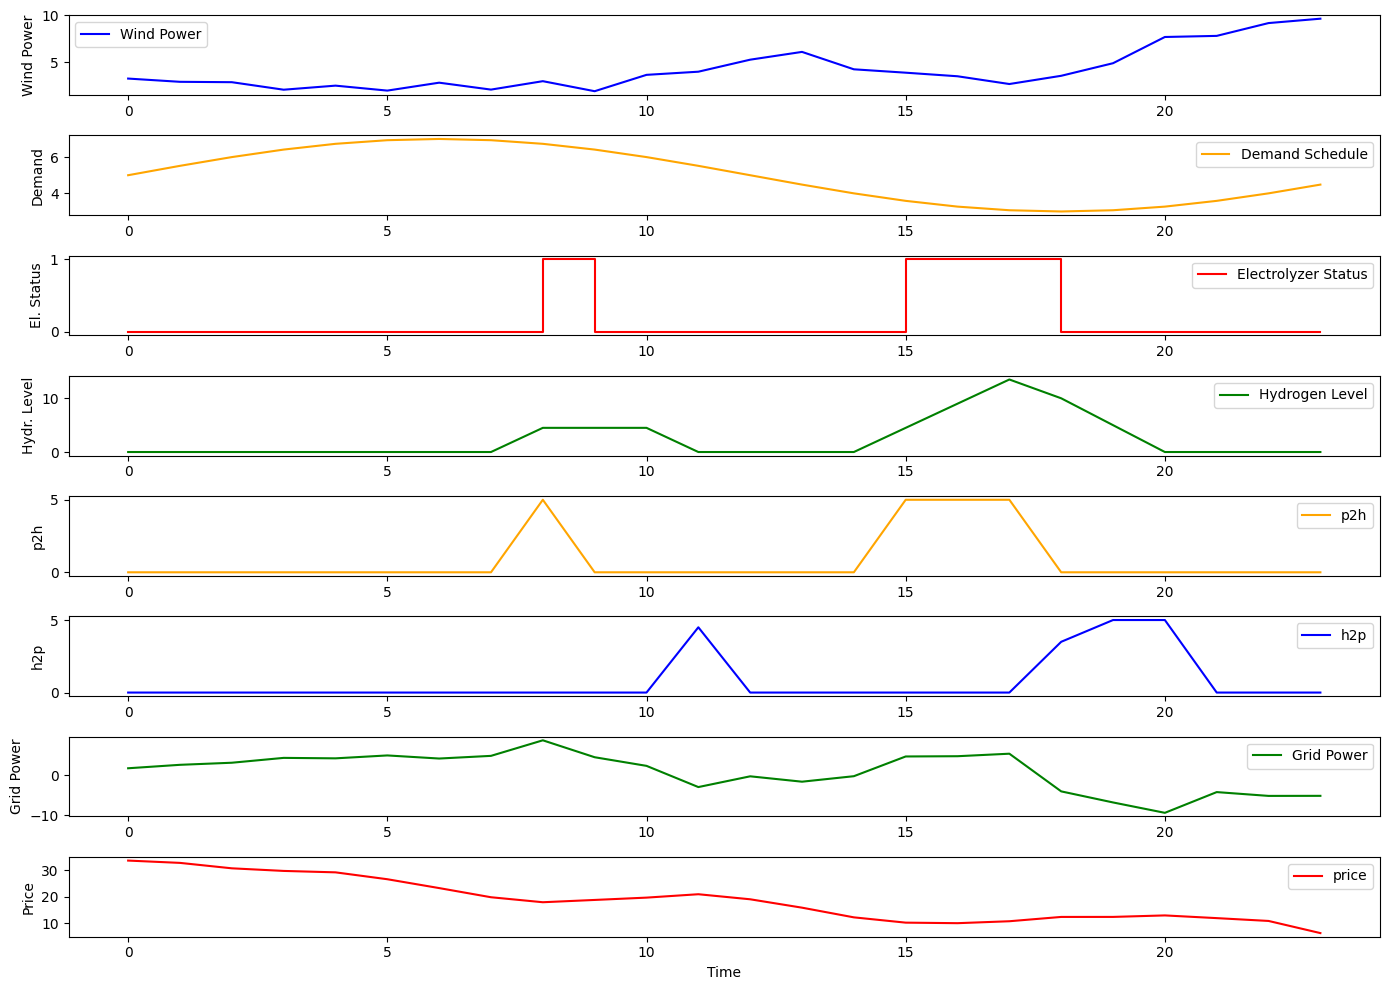

In [32]:
# plots 

initial_state = {'hydrogen': 0, 'electrolyzer_status': 0}

times = range(data['num_timeslots'])

# Plot results
plt.figure(figsize=(14, 10))


plt.subplot(8, 1, 1)
plt.plot(times, wind_trajectory, label="Wind Power", color="blue")
plt.ylabel("Wind Power")
plt.legend()

plt.subplot(8, 1, 2)
plt.plot(times, data['demand_schedule'], label="Demand Schedule", color="orange")
plt.ylabel("Demand")
plt.legend()

plt.subplot(8, 1, 3)
plt.step(times, results['electrolyzer_status'], label="Electrolyzer Status", color="red", where="post")
plt.ylabel("El. Status")
plt.legend()


plt.subplot(8, 1, 4)
plt.plot(times, results['hydrogen_storage_level'], label="Hydrogen Level", color="green")
plt.ylabel("Hydr. Level")
plt.legend()


plt.subplot(8, 1, 5)
plt.plot(times, results['power_to_hydrogen'], label="p2h", color="orange")
plt.ylabel("p2h")
plt.legend()


plt.subplot(8, 1, 6)
plt.plot(times, results['hydrogen_to_power'], label="h2p", color="blue")
plt.ylabel("h2p")
plt.legend()


plt.subplot(8, 1, 7)
plt.plot(times, results['grid_power'], label="Grid Power", color="green")
plt.ylabel("Grid Power")
plt.legend()

plt.subplot(8, 1, 8)
plt.plot(times, price_trajectory, label="price", color="red")
plt.ylabel("Price")
plt.xlabel("Time")
plt.legend()



plt.tight_layout()
plt.show()
